In [1]:
# Botorch and Ax imports.
from ax import json_load
from ax.modelbridge.registry import Models
from ax.models.torch.botorch_modular.surrogate import Surrogate
from ax.core.observation import ObservationFeatures
from botorch.models.gp_regression import SingleTaskGP
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
from ax.service.utils.report_utils import exp_to_df

# Other library imports.
import matplotlib.pyplot as plt
import numpy as np
import scipy

In [8]:
# Path to BoTorch experiment.
exp_fp = r"C:\Users\ay434\Box\Research\Flood_Sim_Materials\BayesOpt_Paper\Data\BT_exp_campagna_1veg_6sens.json"

# Load the experiment.
exp = json_load.load_experiment(exp_fp)

# Extract parameters.
pars = list(exp.parameters.values())

In [9]:
# Experiment result.
results_df = exp_to_df(exp)
print(results_df.head())
print(results_df.sort_values(by='_run_with_loss', ascending=False))

    _run_with_loss  trial_index arm_name  campagna_n_g trial_status  \
0        -0.035448            0      0_0      0.221417    COMPLETED   
1        -0.009731            0      0_1      0.114391    COMPLETED   
2        -0.001314            0      0_2      0.074818    COMPLETED   
5        -0.103939            1      1_0      0.001000    COMPLETED   
15       -0.050394            2      2_0      0.300000    COMPLETED   

   generation_method  
0              Sobol  
1              Sobol  
2              Sobol  
5            BoTorch  
15           BoTorch  
    _run_with_loss  trial_index arm_name  campagna_n_g trial_status  \
7        -0.000012           13     13_0      0.060571    COMPLETED   
10       -0.000018           16     16_0      0.060029    COMPLETED   
21       -0.000020            8      8_0      0.059537    COMPLETED   
8        -0.000022           14     14_0      0.058853    COMPLETED   
11       -0.000038           17     17_0      0.061263    COMPLETED   
22       

In [31]:
# Create a model with the experiment.
gp_model = Models.BOTORCH_MODULAR(
                experiment=exp,
                surrogate=Surrogate(SingleTaskGP),
                data=exp.eval(),
                botorch_acqf_class=qNoisyExpectedImprovement
            )

In [32]:
ngrid = 100

param_meshgrid = []
indexes = []
for i, param in enumerate(pars):
    param_array = np.linspace(param.lower, param.upper, ngrid)
    param_meshgrid.append(param_array)
    indexes.append(np.arange(0,ngrid))

p_vals = np.zeros((ngrid ** len(pars), len(pars)))
p_idxs = np.zeros((ngrid ** len(pars), len(pars)))
mg = np.meshgrid(*param_meshgrid)
mg_idxs = np.meshgrid(*indexes)
for i, p_ar in enumerate(mg):
    p_vals[:, i] = np.ravel(p_ar)
    p_idxs[:, i] = np.ravel(mg_idxs[i])

# Make the observation features.
obs_feats = []
x_names = [p.name for p in pars]
for row in range(p_vals.shape[0]):
    X = p_vals[row, :]
    param_dict = {x_names[i]: X[i] for i in range(len(X))}
    obs_feats.append(ObservationFeatures(parameters=param_dict))

# Predict on the grid.
fg, cov = gp_model.predict(obs_feats)
model_name = list(fg.keys())[0]
fg = fg[model_name]
cov = cov[model_name][model_name]

# 95% confidence intervals.
UI = fg + 1.96 * np.sqrt(cov)
LI = fg - 1.96 * np.sqrt(cov)
stddev = np.sqrt(cov)


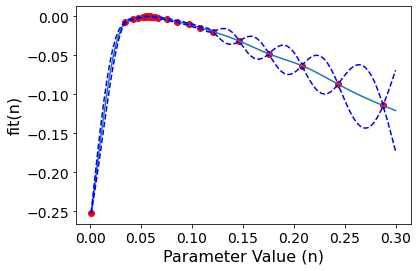

In [33]:
# 1D Plot the evaluation.
fig, ax = plt.subplots()
ax.plot(p_vals, fg)
ax.plot(p_vals, UI, 'b--')
ax.plot(p_vals, LI, 'b--')
ax.scatter(results_df[x_names[0]], results_df[model_name], c='r')
ax.set_xlabel('Parameter Value (n)', fontsize=16)
ax.set_ylabel('fit(n)', fontsize=16)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

In [34]:
# Plot the 2D results as a contour map.

# Populate a 2D grid of data.
func_grid = np.zeros((ngrid, ngrid))
UI_grid = np.zeros((ngrid, ngrid))
LI_grid = np.zeros((ngrid, ngrid))
stddev_grid = np.zeros((ngrid, ngrid))
c = 0
for row in range(p_idxs.shape[0]):
    i = int(p_idxs[row,0])
    j = int(p_idxs[row,1])
    try:
        func_grid[j,i] = fg[c]
        UI_grid[j,i] = UI[c]
        LI_grid[j,i] = LI[c]
        stddev_grid[j,i] = stddev[c]
        c += 1
    except Exception as e:
        print(e, c)

# FUNCTION EVALUATION
fig, ax = plt.subplots(figsize=(10,8))
cf = ax.contourf(mg[0], mg[1], func_grid, levels=10)
# Sobol points.
ax.scatter(results_df.loc[results_df['generation_method'] == 'Sobol',x_names[0]], 
           results_df.loc[results_df['generation_method'] == 'Sobol',x_names[1]], label='Sobol', c='orange')#c='None', edgecolors='orange')
# Botorch points.
ax.scatter(results_df.loc[results_df['generation_method'] == 'BoTorch',x_names[0]], 
           results_df.loc[results_df['generation_method'] == 'BoTorch',x_names[1]], label='BO', c='None', edgecolors='r')
ax.scatter(0.06, 0.2, c='None', edgecolors='g', label='True')
ax.scatter(0.0588, 0.199, c='None', edgecolors='b', label='Best Est.')
ax.set_xlabel('Countryside ($n_1$)', fontsize=16)
ax.set_ylabel('City/Town ($n_2$)', fontsize=16)
cbar = plt.colorbar(cf)
cbar.set_label('-RMSE($n_1$, $n_2$)', fontsize=16)
cbar.ax.tick_params(labelsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.legend(loc='right', fontsize=14)

# UPPER CONFIDENCE INTERVAL.
fig, ax = plt.subplots(figsize=(10,8))
cf = ax.contourf(mg[0], mg[1], stddev_grid, levels=10)
# Sobol points.
ax.scatter(results_df.loc[results_df['generation_method'] == 'Sobol',x_names[0]], 
           results_df.loc[results_df['generation_method'] == 'Sobol',x_names[1]], label='Sobol', c='orange')#c='None', edgecolors='orange')
# Botorch points.
ax.scatter(results_df.loc[results_df['generation_method'] == 'BoTorch',x_names[0]], 
           results_df.loc[results_df['generation_method'] == 'BoTorch',x_names[1]], label='BO', c='None', edgecolors='r')
ax.scatter(0.06, 0.2, c='None', edgecolors='g', label='True')
ax.scatter(0.0588, 0.199, c='None', edgecolors='b', label='Best Est.')
ax.set_xlabel('Countryside ($n_1$)', fontsize=16)
ax.set_ylabel('City/Town ($n_2$)', fontsize=16)
cbar = plt.colorbar(cf)
cbar.set_label('Std. Dev. ($\sigma$)', fontsize=16)
cbar.ax.tick_params(labelsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.legend(loc='right', fontsize=14)


IndexError: index 1 is out of bounds for axis 1 with size 1

In [35]:
# Plot 2D 95% CI.


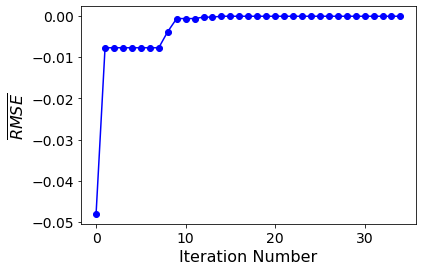

In [36]:
# Plot the performance over each iteration.
best_func = []
for i in range(results_df.shape[0]):
    # Get the first i rows of the results.
    sample_df = results_df.iloc[:i+1,:]
    
    # Maximum function value of the sample rows.
    sort_sample_df = sample_df.sort_values(by='_run_with_loss', ascending=False)
    sort_sample_df.reset_index(inplace=True)
    best_func.append(sort_sample_df.loc[0, '_run_with_loss'])
    
fig, ax = plt.subplots()
ax.plot(best_func, 'b-o')
ax.set_xlabel('Iteration Number', fontsize=16)
ax.set_ylabel('$\overline{RMSE}$', fontsize=16)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

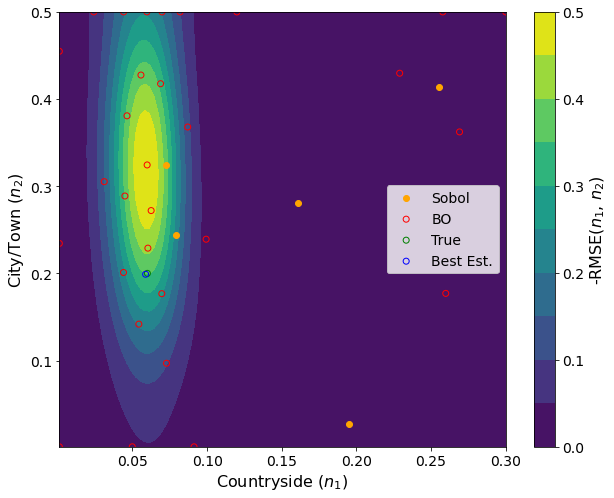

In [9]:
# Plot the probability map.

# Compute z-statistic at all locations in the domain. 
f_max = np.max(func_grid[:])
z = (func_grid - f_max) / stddev_grid
Pz = scipy.stats.norm.cdf(z)

fig, ax = plt.subplots(figsize=(10,8))
cf = ax.contourf(mg[0], mg[1], Pz, levels=10)
# Sobol points.
ax.scatter(results_df.loc[results_df['generation_method'] == 'Sobol',x_names[0]], 
           results_df.loc[results_df['generation_method'] == 'Sobol',x_names[1]], label='Sobol', c='orange')#c='None', edgecolors='orange')
# Botorch points.
ax.scatter(results_df.loc[results_df['generation_method'] == 'BoTorch',x_names[0]], 
           results_df.loc[results_df['generation_method'] == 'BoTorch',x_names[1]], label='BO', c='None', edgecolors='r')
ax.scatter(0.06, 0.2, c='None', edgecolors='g', label='True')
ax.scatter(0.0588, 0.199, c='None', edgecolors='b', label='Best Est.')
ax.set_xlabel('Countryside ($n_1$)', fontsize=16)
ax.set_ylabel('City/Town ($n_2$)', fontsize=16)
cbar = plt.colorbar(cf)
cbar.set_label('-RMSE($n_1$, $n_2$)', fontsize=16)
cbar.ax.tick_params(labelsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.legend(loc='right', fontsize=14)
# ax.set_xlim(0.05, 0.07)
# ax.set_ylim(0.1, 0.3)